# Классификация изображения одежды по стилю на основе собранных референсов.

## Обзор данных

Импортируем необходимые библиотеки.

In [20]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore', 
                       category=UserWarning, 
                       module='keras')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set()

# Фиксируем случайность
random_seed = 42
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf
tf.random.set_seed(random_seed)

Напечатаем на экране 15 фотографий и проанализируем.

In [2]:
# Выгружаем изображения из папок
data_path = 'dataset'
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse',
    seed=random_seed)

Found 67 images belonging to 2 classes.


Датасет содержит 67 изображений принадлежащих 2 классам: old money и grunge.

Визуализируем случайные 8 изображений.

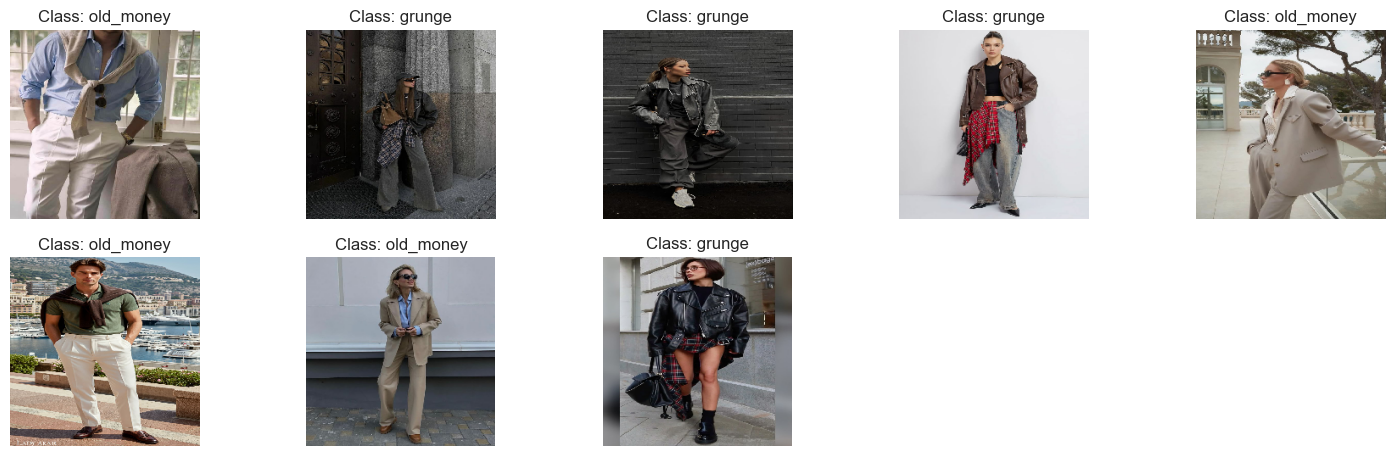

In [3]:
# Извлекаем случайные 8 изображений и выводим их на экран
img_batch, class_batch = next(datagen_flow)
class_batch = ['old_money' if label == 1 else 'grunge' for label in class_batch]
plt.figure(figsize=(15, 7))
for i in range(8):
    plt.subplot(3, 5, i + 1)
    plt.imshow(img_batch[i])
    plt.title(f'Class: {class_batch[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Вывод:** датасет собран корректно, классы распределены правильно. Мы будем иметь дело с 67 изображениями двух классов.

## Обучение модели

Возьмем предобученную на ImageNet модель MobileNetV2. Нам нужен всего один нейрон с активацией Sigmoid, который вернёт класс. 

В качестве функции потерь мы взяли BCE, а скорость обучения уменьшили до 0.001.

In [4]:
# Загрузка тренировочных данных
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=8,
        class_mode='sparse',
        subset='training',
        seed=random_seed
    )
    
    return train_datagen_flow

# Загрузка тестовых данных
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=8,
        class_mode='sparse',
        subset='validation',
        seed=random_seed,
        shuffle=False 
    )
    
    return test_datagen_flow


# Создание модели архитектуры MobileNetV2
def create_model(input_shape): 
    backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

# Обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    model = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=False
    )
    
    return model

Теперь обучим модель на наших данных.

In [5]:
# Создаем и обучаем модель
model = create_model(input_shape=(224, 224, 3))
train_data = load_train(data_path)
test_data = load_test(data_path)
trained_model = train_model(
    model=model,
    train_data=train_data,
    test_data=test_data,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Found 48 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
Epoch 1/5
6/6 - 9s - 1s/step - accuracy: 0.2292 - loss: 0.8721 - val_accuracy: 0.7368 - val_loss: 0.6254
Epoch 2/5
6/6 - 2s - 373ms/step - accuracy: 0.5625 - loss: 0.6779 - val_accuracy: 0.8947 - val_loss: 0.4867
Epoch 3/5
6/6 - 2s - 374ms/step - accuracy: 0.7292 - loss: 0.5644 - val_accuracy: 0.8421 - val_loss: 0.4459
Epoch 4/5
6/6 - 2s - 369ms/step - accuracy: 0.8958 - loss: 0.4355 - val_accuracy: 1.0000 - val_loss: 0.3496
Epoch 5/5
6/6 - 2s - 371ms/step - accuracy: 0.9167 - loss: 0.3678 - val_accuracy: 1.0000 - val_loss: 0.3032


Мы видим, что за 5 эпох модель смогла обучиться до точности 100% на валидационной выборке. Сохраним результат.

In [6]:
# Сохранение модели
model.save('wardrobe_model.keras')

### Матрица ошибок

Посмотрим на матрицу ошибок полученной модели.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 910ms/step


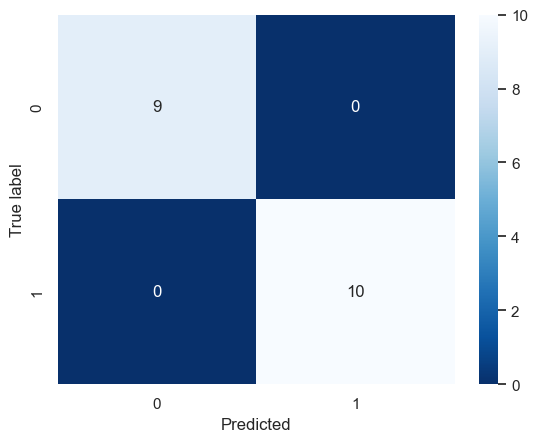

In [7]:
# Получаем предсказания и  визуализируем матрицу ошибок
test_data.reset()
y_true = test_data.classes
y_pred = (model.predict(test_data, steps=len(test_data)) > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

В нашем случае и ошибки 1, и ошибки 2 рода полностью исключены. Модель не определяет положительный класс как отрицательный и наоборот.

### Loss-функция 

Посмотрим на функцию потерь модели.

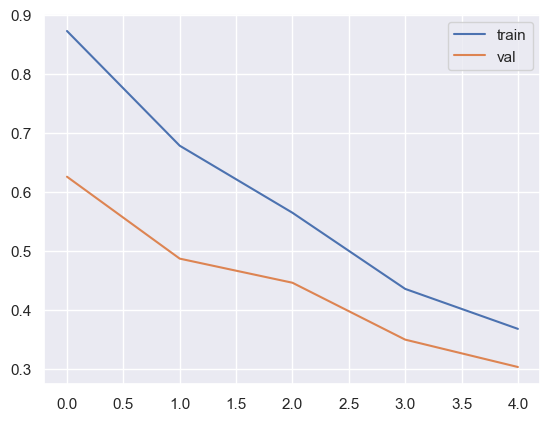

In [11]:
# Визуализируем для тренировочной и валидационной выборки
plt.plot(trained_model.history['loss'], label='train')
plt.plot(trained_model.history['val_loss'], label='val')
plt.legend()
plt.show()

Мы видим, что и на тренировочной и на валидационной выборке функция потерь спадает равномерно. Модель обобщает данные достаточно хорошо, её обучение проходит стабильно и она не переобучается.

**Вывод:** таким образом, мы обучили MobileNetV2 с замороженными весами на 5 эпохах и достигли точности 100%, а также исключили ошибки 1 и 2 рода - precision и recall равны 1.

## Тестирование модели 

Отберем из интернета 4 фотографии в стиле grunge и old money для проверки модели.

In [30]:
# Выгружаем изображения из папки
test_data_path = 'test_images'
datagen_test = ImageDataGenerator(rescale=1./255)
datagen_flow_test = datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=4,
    class_mode=None,   
    shuffle=False, 
    seed=random_seed)

Found 4 images belonging to 2 classes.


Получим предсказания и оценим их соответствие классам.

In [31]:
y_test_pred = (model.predict(datagen_flow_test, steps=len(test_data)) > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


Виузализируем полученные предсказания и изображения.

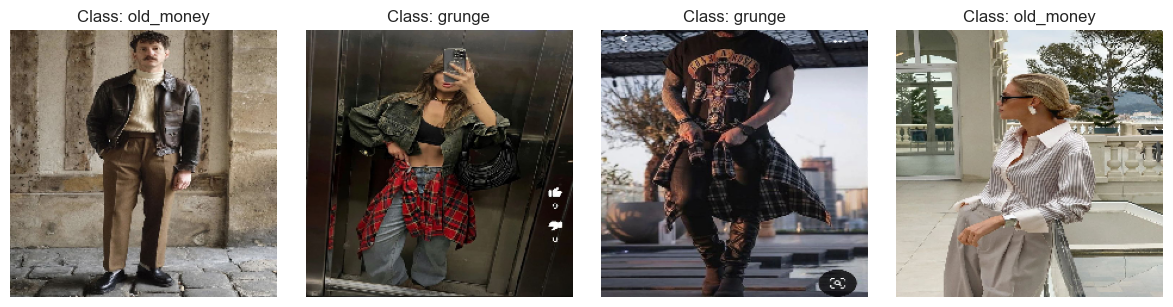

In [38]:
# Извлекаем 4 изображения и выводим их на экран с предсказанными классами
datagen_flow_test.reset()
img_batch = next(datagen_flow_test)
class_batch = y_test_pred
class_batch = ['old_money' if label == 1 else 'grunge' for label in class_batch]
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img_batch[i])
    plt.title(f'Class: {class_batch[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Вывод:** таким образом, мы протестировали модель и увидели, что классы тестовых изображений соответствуют действительности.

## Общий вывод
Мы обучили модель предсказывать стиль одежды по изображению на основе собранных референсов. Для этого мы использовали предобученную модель MobileNetV2, которая на валидации показала точность 100%.

Однако данные метрики и предсказания были получены из небольшой выборки, что может быть статистически не выверено, и неизвестно, как модель поведет себя с бОльшим количеством изображений.

Поэтому цель дальнейшего исследования состоит в сборе более крупного датасета, fine tuning модели, а также изменение ее архитектуры или использование других предобученных моделей.